In [399]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random
import time
import math
import networkx as nx
import matplotlib.pyplot as plt

# Problem 1

Code to randomly generate the programming problems. The generate function randomly spawns anchor points, sensor locations as well as an adjacency matrix which enumerates which sensors are connected to which anchors/sensors

In [400]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

The following code forces the sensors to be located within the convex hull of the anchors.

In [401]:
def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6., 6.])
    elif(n == 2):
        a = np.array([[-6., 15.], [-6., -15.], [8., 0.]])
    elif(n == 3):
        a = np.array([[-6., 15.,-10.], [-6., -15.,-10.], [8., 0., -10.], [0., 0., 10.]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

## SOCP

Solve the SOCP problem with n dimensions and npoints sensors

In [405]:
def SOCP(n, npoints, convex, niters, printOut = False, timing = True):
    #Generate the anchors, sensor locations and the corresponding adjacency matrix
    totalRMSE = 0
    start = time.time()
    for k in range(niters):
        while True:
            try:
                if convex:
                    (a, p, adjacency) = generate(n, npoints)
                else:
                    (a, p, adjacency) = generate_inside_hull(n, npoints)

                # Compute the Euclidian distances to the anchor points
                adjSize = len(p) + len(a)
                asize = len(a)
                d = []

                #Retrieve the distances
                for i in range(adjSize):
                    for j in range(adjSize):
                        if(j > i and adjacency[i][j] > 0 and i < asize):
                            d.append((adjacency[i][j], j - asize, i, True))
                        elif(j > i and adjacency[i][j] > 0):
                            d.append((adjacency[i][j], i - asize, j - asize, False))

                # Construct the CVX variables to minimize
                x = [cvx.Variable(n) for i in range(len(p))]

                states = []
                constr = []

                #Construct the obj fcn as well as the constraints
                cost = cvx.norm(0)
                for (distance, i, j, truth) in d:
                    if(truth):
                        constr.append(cvx.norm(x[i] - a[j], 2) ** 2 <= distance ** 2)
                    else:
                        constr.append(cvx.norm(x[i] - x[j], 2) ** 2 <= distance ** 2)

                states.append(cvx.Problem(cvx.Minimize(cost), constr))

                # Add the states and solve the problem    
                prob = sum(states)
                prob.solve()
                
                if printOut:
                    print "Anchor points: ", a
                    
                RMSE = 0
                if(n == 1): #Solves it more or less
                    for i, elem in enumerate(x):
                        soln1 = elem.value
                        point1 = p[i]
                        if printOut:
                            print("Sensor " + str(i) + " is at " + str(soln1) + " and the actual value is " + str(point1))
                        RMSE += np.linalg.norm(soln1 - point1) ** 2
                elif(n == 2): #Can't solve this)
                    for i, elem in enumerate(x):
                        soln1 = elem.value.A.flatten()
                        soln1 = ['%.4f' % elem for elem in soln1]
                        soln1 = [float(elem) for elem in soln1]
                        point1 = ['%.4f' % elem for elem in p[i]]
                        point1 = [float(elem) for elem in point1]
                        if printOut:
                            print("Sensor " + str(i) + " is at " + str(soln1) + " and the actual value is " + str(point1))
                        RMSE += np.linalg.norm(np.asarray(soln1) - np.asarray(point1)) ** 2
                else:
                    for i, elem in enumerate(x):
                        soln1 = elem.value.A.flatten()
                        soln1 = ['%.4f' % elem for elem in soln1]
                        soln1 = [float(elem) for elem in soln1]
                        point1 = ['%.4f' % elem for elem in p[i]]
                        point1 = [float(elem) for elem in point1]
                        if printOut:
                            print("Sensor " + str(i) + " is at " + str(soln1) + " and the actual value is " + str(point1))
                        RMSE += np.linalg.norm(np.asarray(soln1) - np.asarray(point1)) ** 2
            except:
                continue
            break
    
        totalRMSE += RMSE
        
        end = time.time()
        if(n == 2 and printOut):
            G=nx.Graph()

            for i in range(n+1):
                G.add_node(i,pos=a[i])

            for i in range(npoints):
                G.add_node(n+1+i,pos=p[i])

            pos=nx.get_node_attributes(G,'pos')

            nx.draw_networkx_nodes(G,pos,
                                   nodelist=[i for i in range(n+1)],
                                   node_color='r',
                                   node_size=100,
                                   alpha=0.8,
                                   with_labels=True)
            nx.draw_networkx_nodes(G,pos,
                                   nodelist=[i for i in range(n+1,npoints+n+1)],
                                   node_color='b',
                                   node_size=100,
                                   alpha=0.8,
                                   with_labels=True)
            for i in range(npoints+n+1):
                for j in range(n+1,npoints+n+1):
                    if(adjacency[j,i] > 0.):
                        G.add_edge(i,j)

            nx.draw_networkx_edges(G, pos)
            nx.draw_networkx_labels(G, pos,font_color='w',font_size=8,font_weight='bold')
            plt.draw()  # pyplot draw()
            
    if timing:
        print "Total time elapsed(sec): ", end - start
    print "Average Root Mean Squared Error: ", math.sqrt(totalRMSE/niters)

Anchor points:  [[-3.37159979  0.45506746]
 [ 0.75319662  2.52610846]
 [ 2.65298862  2.99230892]]
Sensor 0 is at [0.2615, 2.1079] and the actual value is [3.2022, -3.7281]
Sensor 1 is at [-1.4062, 1.3637] and the actual value is [-1.9012, 2.1977]
Sensor 2 is at [1.3375, 2.4623] and the actual value is [3.5845, 0.9367]
Sensor 3 is at [-1.8815, 1.1393] and the actual value is [-2.9923, 2.3902]
Sensor 4 is at [0.8811, 2.3201] and the actual value is [4.4744, -3.02]
Sensor 5 is at [-2.3039, 0.9441] and the actual value is [-4.0468, 1.9724]
Sensor 6 is at [1.0157, 2.3594] and the actual value is [4.504, -1.5511]
Sensor 7 is at [0.9934, 2.3675] and the actual value is [4.4452, -3.9444]
Sensor 8 is at [1.1749, 2.4036] and the actual value is [4.7054, 0.2332]
Sensor 9 is at [1.2107, 2.3997] and the actual value is [2.1503, 1.0385]
Total time elapsed(sec):  0.154807806015
Average Root Mean Squared Error:  14.088005235


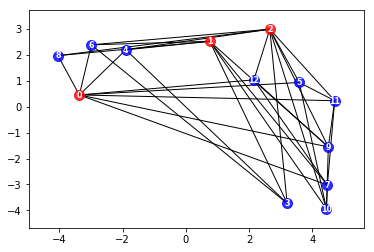

In [406]:
#Solve 2-D with 10 sensors outside the convex hull
SOCP(2, 10, True, 1, True)

Anchor points:  [[ -6.  15.]
 [ -6. -15.]
 [  8.   0.]]
Sensor 0 is at [3.4504, 4.7177] and the actual value is [3.4505, 4.7178]
Sensor 1 is at [-3.2187, 3.9301] and the actual value is [-1.137, 4.3267]
Sensor 2 is at [-3.9177, 3.5643] and the actual value is [-3.9177, 3.5643]
Sensor 3 is at [4.3217, 1.841] and the actual value is [4.3217, 1.841]
Sensor 4 is at [2.8746, 1.5629] and the actual value is [2.8746, 1.5629]
Sensor 5 is at [0.6261, -1.593] and the actual value is [1.9492, -2.2667]
Sensor 6 is at [0.4349, -3.2459] and the actual value is [2.806, -4.6094]
Sensor 7 is at [0.0618, 0.2883] and the actual value is [0.0618, 0.2883]
Sensor 8 is at [-2.1504, -4.4019] and the actual value is [-2.1504, -4.4019]
Sensor 9 is at [4.6062, 3.6363] and the actual value is [1.0624, -1.2807]
Total time elapsed(sec):  0.356856822968
Average Root Mean Squared Error:  7.13525659455


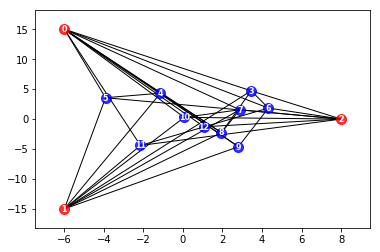

In [407]:
#Solve 2-D with 10 sensors inside the convex hull
SOCP(2, 10, False, 1, True)

In [408]:
#Solve 1-D with 10 sensors randomly generated
SOCP(1, 10, True, 100)

Total time elapsed(sec):  8.29544711113
Average Root Mean Squared Error:  9.42692399813


In [409]:
#Solve 1-D with 10 sensors inside the convex hull
SOCP(1, 10, False, 100)

Total time elapsed(sec):  9.96485209465
Average Root Mean Squared Error:  5.81985405852


In [410]:
#Solve 2-D with 10 sensors outside the convex hull
SOCP(2, 10, True, 100)

Total time elapsed(sec):  11.263933897
Average Root Mean Squared Error:  12.2941148022


In [411]:
#Solve 2-D with 10 sensors inside the convex hull
SOCP(2, 10, False, 100)

Total time elapsed(sec):  24.3332779408
Average Root Mean Squared Error:  7.04751513325


In [412]:
#Solve 3-D with 10 sensors outside the convex hull
SOCP(3, 10, True, 100)

Total time elapsed(sec):  9.46475696564
Average Root Mean Squared Error:  15.7684826823


In [413]:
#Solve 3-D with 10 sensors inside the convex hull
SOCP(3, 10, False, 100)

Total time elapsed(sec):  10.029624939
Average Root Mean Squared Error:  15.0895796464


## SDP

In [414]:
def SDP(n, npoints, convex, niter, printOut = False):
    start = time.time()
    totalRMSE = 0
    for iteration in range(niter):
        if convex:
            (a, p, adjacency) = generate(n, npoints)
        else:
            (a, p, adjacency) = generate_inside_hull(n, npoints)

        # Compute the Euclidian distances to the anchor points
        adjSize = len(p) + len(a)
        asize = len(a)
        d = []

        #Retrieve the distances
        for i in range(adjSize):
            for j in range(adjSize):
                if(j > i and adjacency[i][j] > 0 and i < asize):
                    d.append((adjacency[i][j], j - asize, i, True))
                elif(j > i and adjacency[i][j] > 0):
                    d.append((adjacency[i][j], i - asize, j - asize, False))

        T = n + npoints

        # We are working in R^2

        #This creates a 3x3 semipositive definite matrix which we will 
        #use as part of our constraints
        z = cvx.Semidef(T)

        eyeConstraint = []
        anchorConstraints = []
        pointConstraints = []

        for i in range(n):
            temp = np.zeros((T,T))
            temp[i][i] = 1
            eyeConstraint.append(temp)

        temp = np.zeros((T,T))
        for i in range(n):
            for j in range(n):
                temp[i][j] = 1
        eyeConstraint.append(temp)

        for (distance, i, j, truth) in d:
            if truth:
                temp = np.zeros(npoints)
                temp[i] = -1.
                anchorConstraints.append((np.outer(np.append(a[j], temp), np.append(a[j], temp)), distance))
            else:
                tempi = np.zeros(npoints)
                tempj = np.zeros(npoints)
                tempi[i] = 1.
                tempj[j] = 1.
                temp = tempi - tempj
                corner = np.zeros(n)
                temp = np.append(corner, temp)
                pointConstraints.append((np.outer(temp,temp), distance))

        #Another empty states list
        states = []

        cost = cvx.norm(0)

        #The four constraints in the SDP relaxation problem
        #Note that the last constraint forces z to be SPD
        constr = []

        for i, mat in enumerate(eyeConstraint):
            if i < len(eyeConstraint) - 1:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == 1)
            else:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == n)

        for mat in anchorConstraints:
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat[0], z)) ==  mat[1] ** 2)

        for mat in pointConstraints:
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat[0], z)) ==  mat[1] ** 2)

        constr.append(z >> 0)

        #Add the constraints and cost function
        states.append(cvx.Problem(cvx.Minimize(cost), constr))

        #Solve the SDP relaxation problem
        prob = sum(states)
        prob.solve();    
    
        RMSE = 0
        for i in range(npoints):
            soln1 = z.value.A[0:n, i + n]
            point1 = p[i]
            if printOut:
                print("Sensor " + str(i) + " is located at " + str(soln1) + " and the actual value is " + str(point1))
            RMSE += np.linalg.norm(np.asarray(soln1) - np.asarray(point1)) ** 2
    
    totalRMSE += RMSE
    end = time.time()
    print "Total Time Elapsed: ", end - start
    print "Average RMSE: ", math.sqrt(totalRMSE / niter)

In [415]:
SDP(2, 10, True, 1, True)

Sensor 0 is located at [ 2.60183324 -1.52723278] and the actual value is [ 3.12677165 -1.02036914]
Sensor 1 is located at [ 4.01217891 -2.54100548] and the actual value is [ 4.92048762 -1.6388582 ]
Sensor 2 is located at [-0.25417881  2.91698575] and the actual value is [-0.26848899  2.92040864]
Sensor 3 is located at [-4.24802974  0.06350305] and the actual value is [-4.29013235  0.04822609]
Sensor 4 is located at [ 2.2379841  -1.82537448] and the actual value is [ 2.28211097 -1.76027554]
Sensor 5 is located at [-3.08443109  3.079777  ] and the actual value is [-3.09321805  3.08471545]
Sensor 6 is located at [ 2.41771089  4.9431743 ] and the actual value is [ 2.39123224  4.9347858 ]
Sensor 7 is located at [ 0.6260222  -4.43872769] and the actual value is [ 0.66344206 -4.47830271]
Sensor 8 is located at [ 2.72116559  1.35877923] and the actual value is [ 1.43189768  2.32021695]
Sensor 9 is located at [-0.58600058 -0.18755463] and the actual value is [-0.60648842 -0.18397399]
Total Time

In [416]:
#Solve 1-D case with SDP with 10 sensors outside the convex hull
SDP(1, 10, True, 100, False)

Total Time Elapsed:  9.29977798462
Average RMSE:  0.181446787146


In [417]:
#Solve 1-D case with SDP with 10 sensors inside the convex hull
SDP(1, 10, False, 100, False)

Total Time Elapsed:  10.9166190624
Average RMSE:  0.00143507882466


In [418]:
#Solve 2-D case with SDP with 10 sensors outside the convex hull
SDP(2, 10, True, 100, False)

Total Time Elapsed:  15.8361301422
Average RMSE:  0.061899460107


In [419]:
#Solve 2-D case with SDP with 10 sensors inside the convex hull
SDP(2, 10, False, 100, False)

Total Time Elapsed:  34.5125718117
Average RMSE:  0.0101581084169


In [420]:
#Solve 3-D case with SDP with 10 sensors outside the convex hull
SDP(3, 10, True , 100, False)

Total Time Elapsed:  21.5549440384
Average RMSE:  1.08872296859


In [421]:
#Solve 3-D case with SDP with 10 sensors inside the convex hull
SDP(3, 10, False, 100, False)

Total Time Elapsed:  33.7564148903
Average RMSE:  1.02207095077


## Unconstrained Optimization

In [422]:
# Note that the summations are unrolled for the ease of coding.
# The objective function is for the distances d11, d12, d22, d23, dhat12

# We update the objective function seen with two sensors and three anchors
def SNL(a, x, d):
    sum_obj = 0
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_obj += ((np.linalg.norm(a[j] - x[i]) ** 2) - distance ** 2) ** 2
        else:
            sum_obj += (((np.linalg.norm(x[i] - x[j]) ** 2) - distance ** 2) ** 2)/2
    
    return sum_obj

# Here, we perform the gradient of the objective function
# Note that we keep the gradients for the two different
# sensors separate and stored in sum_x[0] and sum_x[1]
# respectively
def dSNL(a, x, d, npoints, n):
    sum_x = np.zeros((npoints, n))
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_x[i] += 4 * (np.linalg.norm(a[j] - x[i]) ** 2 - distance ** 2) * (-a[j] + x[i])
        else:
            sum_x[i] += 4 * (np.linalg.norm(x[i] - x[j]) ** 2 - distance ** 2) * (x[i] - x[j])

    return sum_x

# Updated steepest descent where we perform it twice for the two
# different sensors
def steepest_descent_2(op, dop, a, xin, d, niter, npoints, n):
    x = np.copy(xin)
    
    for i in range(0, niter):
            direction = dop(a, x, d, npoints, n)
            
            alpha = 1.
            
            for j in range(npoints):
                while(op(a, x  - alpha * direction, d) > op(a, x, d) \
                      - 0.5 * alpha * np.dot(direction[j], direction[j])):
                        if alpha < 1e-9:
                            break
                        alpha *= 0.9

            x -= alpha * direction
    
    return x

In [423]:
import copy
def unconstrained(n, npoints, convex, niter, printOut):
    start = time.time()
    totalRMSE = 0
    for iteration in range(niter):
        if convex:
            (a, p, adjacency) = generate(n, npoints)
        else:
            (a, p, adjacency) = generate_inside_hull(n, npoints)

        # Compute the Euclidian distances to the anchor points
        adjSize = len(p) + len(a)
        asize = len(a)
        d = []

        #Retrieve the distances
        for i in range(adjSize):
            for j in range(adjSize):
                if(j > i and adjacency[i][j] > 0 and i < asize):
                    d.append((adjacency[i][j], j - asize, i, True))
                elif(j > i and adjacency[i][j] > 0):
                    d.append((adjacency[i][j], i - asize, j - asize, False))

        x = [np.random.rand(n) for i in range(npoints)]

        d2 = copy.copy(d)

        for k in range(len(d)):
            (distance, i, j, truth) = d[k]

            if not truth:
                d2.append((distance, j, i, truth))

        soln = steepest_descent_2(SNL, dSNL, a, x, d2, 40, npoints, n)
        RMSE = 0
        for i in range(npoints):
            if printOut:
                print("Sensor " + str(i) + " is located at " + str(soln[i]) + " and the actual value is " + str(p[i]))
            RMSE += np.linalg.norm(np.asarray(soln[i]) - np.asarray(p[i])) ** 2
        totalRMSE += RMSE
    end = time.time()
    print "Total time elapsed: ", end - start
    print "Average RMSE: ", math.sqrt(totalRMSE / niter)

In [424]:
unconstrained(2, 10, True, 1, True)

Sensor 0 is located at [ 1.57835787  4.48574312] and the actual value is [ 1.57463426  4.51521257]
Sensor 1 is located at [-4.06512537  2.13692847] and the actual value is [-4.08220565  2.15065139]
Sensor 2 is located at [-2.72793189 -1.91778923] and the actual value is [-2.78045488 -1.89616651]
Sensor 3 is located at [ 2.47030385 -3.23352364] and the actual value is [ 2.48115864 -3.23807993]
Sensor 4 is located at [-0.75079182 -3.46403899] and the actual value is [-0.62229379 -3.30679818]
Sensor 5 is located at [-2.7915589  -4.33753945] and the actual value is [-2.77358879 -4.33471284]
Sensor 6 is located at [ 0.50210365 -2.89958744] and the actual value is [ 0.50004549 -2.89972821]
Sensor 7 is located at [-1.87179258 -0.98400392] and the actual value is [-1.89172994 -0.92564308]
Sensor 8 is located at [-1.19243939 -1.9041064 ] and the actual value is [-0.63881511 -1.90345735]
Sensor 9 is located at [ 1.78760252  3.77857429] and the actual value is [ 1.17497876  4.27085436]
Total time

In [425]:
#Solve 1-D case with steepest descent with 10 sensors outside the convex hull
SDP(1, 10, True, 100)

Total Time Elapsed:  6.54781889915
Average RMSE:  0.370136491554


In [426]:
#Solve 1-D case with steepest descent with 10 sensors inside the convex hull
SDP(1, 10, False, 100)

Total Time Elapsed:  9.28683900833
Average RMSE:  0.00131113844964


In [427]:
#Solve 2-D case with steepest descent with 10 sensors outside the convex hull
SDP(2, 10, True, 100)

Total Time Elapsed:  13.315559864
Average RMSE:  0.0153179595149


In [428]:
#Solve 2-D case with steepest descent with 10 sensors inside the convex hull
SDP(2, 10, False, 100)

Total Time Elapsed:  33.8117461205
Average RMSE:  0.00616733637123


In [429]:
#Solve 3-D case with steepest descent with 10 sensors outside the convex hull
SDP(3, 10, True, 100)

Total Time Elapsed:  21.8626668453
Average RMSE:  0.842044570965


In [430]:
#Solve 3-D case with steepest descent with 10 sensors inside the convex hull
SDP(3, 10, False, 100)

Total Time Elapsed:  31.5579149723
Average RMSE:  0.372208217592
